<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Emotion_analysis_using_Hugging_Face_and_BERT_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from tqdm.notebook import tqdm

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('/content/Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
df.shape

(21459, 2)

In [10]:
df.Emotion.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [11]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

Let's label encode the sentiments

In [12]:
df = df[df.Emotion.isin(['happy', 'sadness', 'anger', 'fear', 'love', 'surprise'])]

In [13]:
possible_labels = df.Emotion.unique()

In [14]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [15]:
label_dict

{'anger': 1, 'fear': 4, 'happy': 5, 'love': 2, 'sadness': 0, 'surprise': 3}

In [16]:
df.Emotion = df['Emotion'].map(label_dict)
df.head()

,Text,Emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1


importing transformers

In [17]:
import torch
import torch.nn as nn

In [18]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

In [19]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
token_lens = []
for txt in df.Text:
    
    tokens = tokenizer.encode(txt, max_length=512, truncation = True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

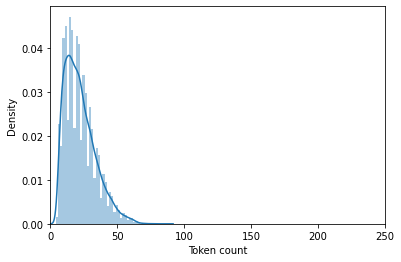

In [23]:
sns.distplot(token_lens)
plt.xlim([0, 250]);
plt.xlabel('Token count')

In [24]:
MAX_LEN = 75

In [25]:
class appletweet(Dataset):
  def __init__(self, Text, targets, tokenizer, max_len):
    self.Text = Text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len


  def __len__(self):
    return len(self.Text)



  def __getitem__(self, item):
    Text = str(self.Text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        Text, 
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        pad_to_max_length = True,
        #padding = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        truncation = True

    ) 
    return {
        'reviews_text' : Text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }   

Training/Validation Split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train, val = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

train.shape, val.shape

((19313, 2), (2146, 2))

Create dataloaders for train and validation data

In [28]:
def create_data_loader(data, tokenizer, max_len, batch_size):

  ds = appletweet(
      Text = data.Text.to_numpy(),
      targets = data.Emotion.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds, 
      batch_size = batch_size,
      num_workers = 2
  )



BATCH_SIZE = 32

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['reviews_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['attention_mask'].shape)
print(data['input_ids'].shape)
print(data['targets'].shape)

torch.Size([32, 75])
torch.Size([32, 75])
torch.Size([32])


Bert Model

In [31]:
bert_model = BertModel.from_pretrained("bert-base-cased", return_dict=False)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment classification 

In [32]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):

    _,pooled_output = self.bert(input_ids = input_ids,
                                attention_mask = attention_mask, return_dict=False)

    output = self.drop(pooled_output)
    return self.out(output)  

In [33]:
n_classes = 6

In [34]:
model = SentimentClassifier(n_classes)
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [36]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 75])
torch.Size([32, 75])


Softmax function

In [37]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1583, 0.2253, 0.1093, 0.0798, 0.2741, 0.1532],
        [0.1995, 0.2371, 0.1471, 0.0977, 0.1740, 0.1446],
        [0.1888, 0.2088, 0.1065, 0.2154, 0.1428, 0.1377],
        [0.1080, 0.2736, 0.1532, 0.0941, 0.1807, 0.1905],
        [0.1621, 0.2025, 0.0789, 0.0965, 0.2655, 0.1945],
        [0.2232, 0.1971, 0.1094, 0.1183, 0.2266, 0.1254],
        [0.3560, 0.2220, 0.1290, 0.1327, 0.0653, 0.0950],
        [0.1978, 0.2455, 0.1440, 0.1134, 0.1554, 0.1439],
        [0.1730, 0.2211, 0.1169, 0.1298, 0.1829, 0.1763],
        [0.1587, 0.2729, 0.1499, 0.0928, 0.1399, 0.1858],
        [0.1489, 0.2879, 0.0978, 0.1379, 0.1663, 0.1612],
        [0.1511, 0.2314, 0.0976, 0.1075, 0.1825, 0.2299],
        [0.1933, 0.3438, 0.1163, 0.1069, 0.1074, 0.1323],
        [0.1380, 0.1802, 0.1646, 0.1332, 0.1838, 0.2002],
        [0.1942, 0.2603, 0.1195, 0.1343, 0.2002, 0.0916],
        [0.2271, 0.1909, 0.1268, 0.1470, 0.1329, 0.1754],
        [0.1852, 0.1857, 0.1133, 0.1016, 0.2141, 0.2001],
        [0.188

In [38]:
model.parameters

<bound method Module.parameters of SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

Use loss function as Cross Entropy

In [39]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)

total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                   num_warmup_steps = total_steps, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

Model on one epoch

In [40]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples):  

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)
    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _,preds = torch.max(outputs, dim = 1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)  


Evaluation

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)

      _,preds = torch.max(outputs, dim = 1)
      loss = loss_fn(outputs, targets)

      correct_predictions +=  torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)  

Results

In [42]:
from collections import defaultdict


In [43]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

Epoch 1/10
----------
Train loss 1.5167477946013015 accuracy 0.40149122352819344
Val   loss 1.1355972070904339 accuracy 0.5745573159366263

Epoch 2/10
----------
Train loss 0.785551752870446 accuracy 0.7352042665562056
Val   loss 0.4173976759261945 accuracy 0.8755824790307548

Epoch 3/10
----------
Train loss 0.3170685116633378 accuracy 0.8984103971418216
Val   loss 0.23059696446665945 accuracy 0.9231127679403541

Epoch 4/10
----------
Train loss 0.18861646252986514 accuracy 0.9304613472790348
Val   loss 0.19702863872653859 accuracy 0.929170549860205

Epoch 5/10
----------
Train loss 0.1394689199884749 accuracy 0.9450629109925957
Val   loss 0.1674727683489704 accuracy 0.9366262814538676

Epoch 6/10
----------
Train loss 0.11387694666018734 accuracy 0.9528814787966654
Val   loss 0.17236584716695635 accuracy 0.939888164026095

Epoch 7/10
----------
Train loss 0.09955159911966038 accuracy 0.9623569616320613
Val   loss 0.19487231983529293 accuracy 0.9417520969245107

Epoch 8/10
----------
